# B08705012 胡家愷 HW5

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Read Dataset

Label =  blazer


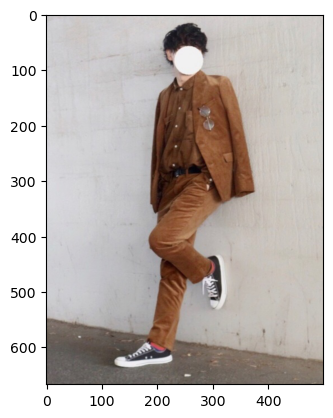

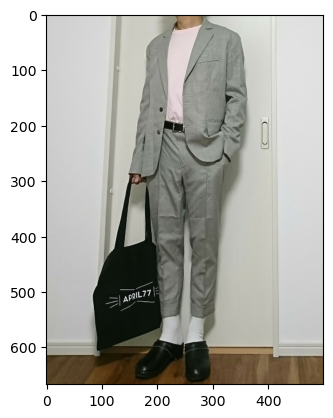

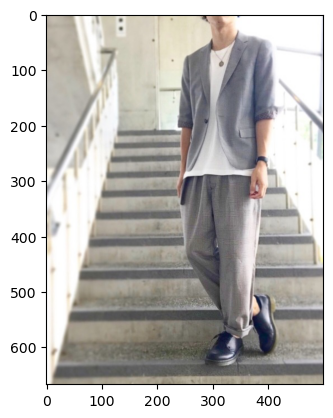

Label =  cardigan


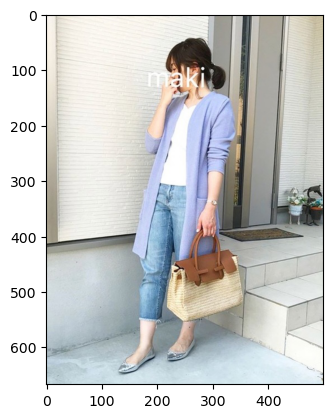

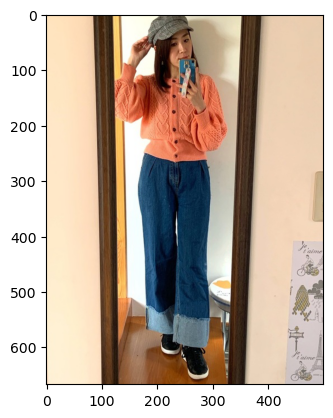

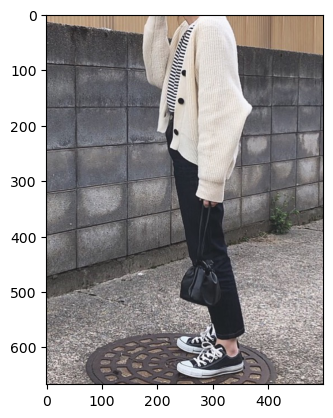

Label =  coat


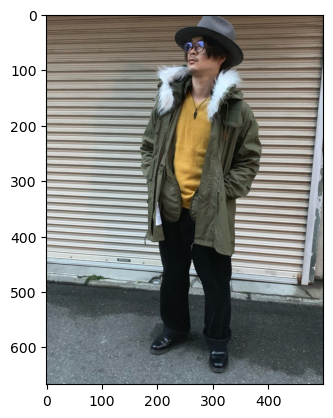

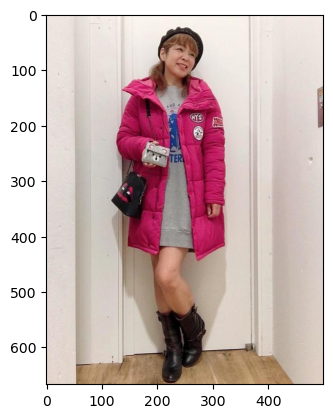

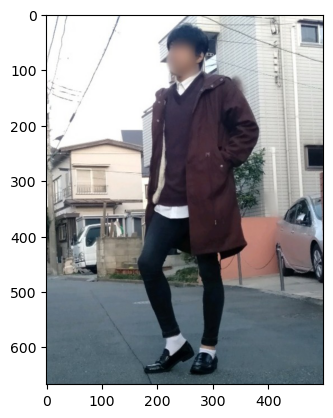

Label =  jacket


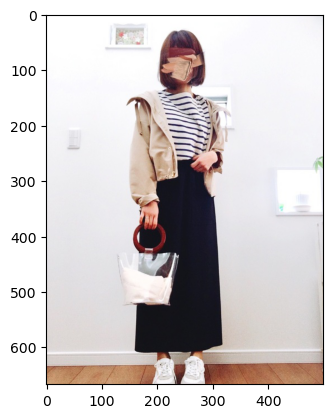

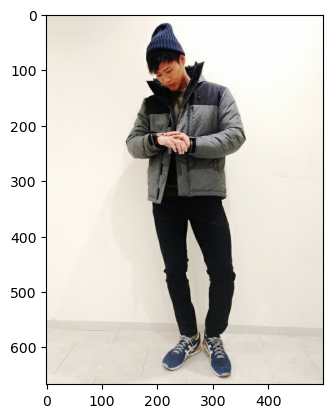

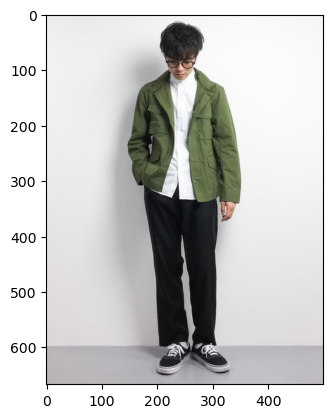

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random

random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("photos/train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

## Q1
列出train, valid, test的總照片數，以及各類別的照片數與比率。

In [38]:
def printDatasetReport(basepath="photos/train"):
    labels = ['blazer', 'cardigan', 'coat', 'jacket', "Total"]
    label_cnt = [0, 0, 0, 0, 0]
    for i in range(4):
        joinpath = os.path.join(basepath, labels[i], "*.jpg")
        cand_fn = glob.glob(joinpath)
        label_cnt[i] = len(cand_fn)
    label_cnt[4] = sum(label_cnt)
    print("Total number of images in ", basepath, " = ", label_cnt[4])
    print("Number of images per label")
    df = pd.DataFrame({'label': labels, 'count': label_cnt})
    df['ratio'] = df['count'] / label_cnt[4] * 100
    df['ratio'] = df['ratio'].apply(lambda x: str("%.2f" % x) + '%')
    display(df)

In [39]:
printDatasetReport("photos/train")

Total number of images in  photos/train  =  1041
Number of images per label


,label,count,ratio
0,blazer,97,9.32%
1,cardigan,237,22.77%
2,coat,296,28.43%
3,jacket,411,39.48%
4,Total,1041,100.00%


In [40]:
printDatasetReport("photos/valid")

Total number of images in  photos/valid  =  105
Number of images per label


,label,count,ratio
0,blazer,7,6.67%
1,cardigan,36,34.29%
2,coat,27,25.71%
3,jacket,35,33.33%
4,Total,105,100.00%


In [41]:
printDatasetReport("photos/test")

Total number of images in  photos/test  =  146
Number of images per label


,label,count,ratio
0,blazer,9,6.16%
1,cardigan,42,28.77%
2,coat,43,29.45%
3,jacket,52,35.62%
4,Total,146,100.00%


我們預期模型在看過比較多照片愈能夠準確辨識，因此在訓練集中各類別比例由高到低依序是 jacket > coat > cardigan > blazer，我們也預期各類別的準確率會是 **jacket > coat > cardigan > blazer**

## Q2
### Data processing
- 解析度調整(Resize)成較短邊為256像素的照片
- 隨機取大小為224x224的影像
- 隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度
- 依照 Pretrained ResNet 的要求調整RGB的均數與標準差
- 測試資料 (Valid and Test) 亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, basepath, transform=None):
        self.basepath = basepath
        self.transform = transform
        self.labels = ['blazer', 'cardigan', 'coat', 'jacket']
        self.label2idx = {'blazer': 0, 'cardigan': 1, 'coat': 2, 'jacket': 3}
        self.imgs = []
        for i in range(4):
            joinpath = os.path.join(basepath, self.labels[i], "*.jpg")
            cand_fn = glob.glob(joinpath)
            for afn in cand_fn:
                self.imgs.append((afn, i))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        afn, label = self.imgs[idx]
        img = Image.open(afn)
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
from torchvision import transforms, models
from torch.utils.data import DataLoader

preprocess_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset_train = Dataset("photos/train", transform=preprocess_train)
dataset_valid = Dataset("photos/valid", transform=preprocess_test)
dataset_test = Dataset("photos/test", transform=preprocess_test)

In [9]:
dataset_train[0][0].shape

torch.Size([3, 224, 224])

In [10]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

### Model Construction
- Resnet50
- 最後一層的Fully Connected Layer 輸出維度改成 4
- 使用 torchvision 提供的pretrained weights (torchvision.models.resnet50(pretrained=True))初始化模型權重。
- Early Stopping的Patient參數設為 20 Epochs。
- Batch size 設為 32。
- 每一個 Epoch 計算一次 Valid Loss，並記錄 Valid Loss 最低的模型。
- 模型訓練最多200個Epochs。
- 使用最佳模型在test資料計算模型 Accuracy, Confusion Matrix, 與 Per-class Accuracy。
- 考慮 SGD 與 ADAM 兩種最佳化演算法。

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
def showLossGraph(train_loss_list, valid_loss_list):
    import seaborn as sns
    import pandas as pd

    df_loss = pd.DataFrame({"train_loss": train_loss_list, "valid_loss": valid_loss_list})

    ax = sns.lineplot(data=df_loss, dashes=False)
    ax.set(xlabel='Number of epoches', ylabel='Loss')

In [32]:
def train(model, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=10, model_path="model.pth", verbose=True, printLossGraph=False):
    best_epoch = 0
    best_valid_loss = 1e10
    best_valid_acc = 0
    best_train_loss = 0
    best_train_acc = 0
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(1, num_epochs+1):
        # traing
        train_loss = 0
        train_correct_cnt = 0
        for i, (imgs, labels) in enumerate(dataloader_train):
            model.train()
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            train_correct_cnt += torch.sum(preds == labels.data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(dataloader_train)
        train_loss_list.append(train_loss)
        train_acc = train_correct_cnt / len(dataloader_train.dataset)

        # validation 
        model.eval()
        valid_loss = 0
        valid_correct_cnt = 0
        for i, (imgs, labels) in enumerate(dataloader_valid):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            valid_correct_cnt += torch.sum(preds == labels.data)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
        valid_loss /= len(dataloader_valid)
        valid_loss_list.append(valid_loss)
        accuracy = valid_correct_cnt / len(dataloader_valid.dataset)
        if verbose:
            print("Epoch %d, train loss = %.4f, train_accuracy = %.4f, valid loss = %.4f, valid_accuracy = %.4f" % (epoch, train_loss, train_acc, valid_loss, accuracy))
        
        # update best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_train_acc = train_acc
            best_valid_acc = accuracy
            best_train_loss = train_loss
            torch.save(model.state_dict(), model_path)
        
        # Early stopping
        if epoch - best_epoch > 20:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best Epoch: {best_epoch}, Training accuracy: {best_train_acc}, Training loss: {best_train_loss}, Valid accuracy: {best_valid_acc}, Valid loss: {best_valid_loss}")
    if printLossGraph:
        showLossGraph(train_loss_list, valid_loss_list)

In [50]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
def test(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        total_correct = 0
        total_cnt = 0
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_cnt += imgs.size(0)
            y_true.extend(labels.data.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    avg_acc = total_correct.double() / total_cnt
    print("Accuracy = %.4f %%" % (avg_acc * 100))
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    labels = ['blazer', 'cardigan', 'coat', 'jacket']
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)

    cm_display.plot()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=dataset_test.labels))

    # calculate per class accuracy
    print("Per class accuracy:")
    for i in range(4):
        total_cnt = np.sum(np.array(y_true) == i)
        correct_cnt = np.sum((np.array(y_true) == i) & (np.array(y_pred) == i))
        print("Accuracy of %5s : %.4f %%" % (dataset_test.labels[i], 100 * correct_cnt / total_cnt))

### Use SGD

Learning rate: 0.001
Epoch 1, train loss = 1.2965, train_accuracy = 0.3689, valid loss = 1.1726, valid_accuracy = 0.4190
Epoch 2, train loss = 1.1130, train_accuracy = 0.5293, valid loss = 1.0274, valid_accuracy = 0.4857
Epoch 3, train loss = 0.9854, train_accuracy = 0.6100, valid loss = 0.9292, valid_accuracy = 0.6476
Epoch 4, train loss = 0.7984, train_accuracy = 0.6859, valid loss = 0.8643, valid_accuracy = 0.6476
Epoch 5, train loss = 0.7041, train_accuracy = 0.7166, valid loss = 0.7875, valid_accuracy = 0.6190
Epoch 6, train loss = 0.5741, train_accuracy = 0.7819, valid loss = 0.7437, valid_accuracy = 0.6857
Epoch 7, train loss = 0.4415, train_accuracy = 0.8425, valid loss = 0.8647, valid_accuracy = 0.7524
Epoch 8, train loss = 0.4043, train_accuracy = 0.8492, valid loss = 0.8164, valid_accuracy = 0.7048
Epoch 9, train loss = 0.3406, train_accuracy = 0.8780, valid loss = 0.8993, valid_accuracy = 0.7143
Epoch 10, train loss = 0.2477, train_accuracy = 0.9183, valid loss = 0.9831, va

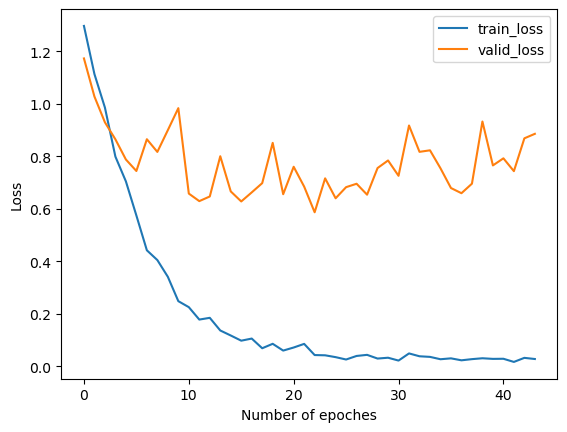

In [37]:
import torchvision.models as models

learning_rates = [0.001]
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    resnet50 = models.resnet50(pretrained=True)
    resnet50.fc = torch.nn.Linear(2048, 4)
    resnet50 = resnet50.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(resnet50.parameters(), lr=lr, momentum=0.9)

    train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q2_sgd_{str(lr)}.ckpt", printLossGraph=True, verbose=True)

try learning_rates = [0.01, 0.005, 0.0005, 0.0001]

In [38]:
import torchvision.models as models

learning_rates = [0.01, 0.005, 0.0005, 0.0001]
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    resnet50 = models.resnet50(pretrained=True)
    resnet50.fc = torch.nn.Linear(2048, 4)
    resnet50 = resnet50.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(resnet50.parameters(), lr=lr, momentum=0.9)

    train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q2_sgd_{str(lr)}.ckpt", printLossGraph=False, verbose=False)

Learning rate: 0.01
Early stopping at epoch 29
Best Epoch: 8, Training accuracy: 0.8107588887214661, Training loss: 0.5066765754511862, Valid accuracy: 0.6952381134033203, Valid loss: 0.827523872256279
Learning rate: 0.005
Early stopping at epoch 47
Best Epoch: 26, Training accuracy: 0.9711815118789673, Training loss: 0.08103958681000001, Valid accuracy: 0.8095238208770752, Valid loss: 0.7516107074916363
Learning rate: 0.0005
Early stopping at epoch 46
Best Epoch: 25, Training accuracy: 0.9529298543930054, Training loss: 0.1412463147531856, Valid accuracy: 0.7904762029647827, Valid loss: 0.5296436846256256
Learning rate: 0.0001
Early stopping at epoch 137
Best Epoch: 116, Training accuracy: 0.9596541523933411, Training loss: 0.1342696650235942, Valid accuracy: 0.7809523940086365, Valid loss: 0.574282243847847


### Use Adam
- try learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]

In [40]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    resnet50 = models.resnet50(pretrained=True)
    resnet50.fc = torch.nn.Linear(2048, 4)
    resnet50 = resnet50.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr)

    train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q2_adam_{str(lr)}.ckpt", verbose=False, printLossGraph=False)

Learning rate: 0.01
Early stopping at epoch 38
Best Epoch: 17, Training accuracy: 0.41690680384635925, Training loss: 1.233038042530869, Valid accuracy: 0.380952388048172, Valid loss: 1.2038773894309998
Learning rate: 0.005
Early stopping at epoch 121
Best Epoch: 100, Training accuracy: 0.5561959743499756, Training loss: 1.033554171070908, Valid accuracy: 0.5333333611488342, Valid loss: 1.0943255126476288
Learning rate: 0.001
Early stopping at epoch 44
Best Epoch: 23, Training accuracy: 0.6532180309295654, Training loss: 0.8563022450967268, Valid accuracy: 0.6000000238418579, Valid loss: 0.8958437889814377
Learning rate: 0.0005
Early stopping at epoch 33
Best Epoch: 12, Training accuracy: 0.8059557676315308, Training loss: 0.489242493203192, Valid accuracy: 0.6571428775787354, Valid loss: 0.7030587643384933
Learning rate: 0.0001
Early stopping at epoch 27
Best Epoch: 6, Training accuracy: 0.9346781373023987, Training loss: 0.20351941296548554, Valid accuracy: 0.7714285850524902, Valid 

### 選擇 SGD 
- Learning rate: 0.0005
- 該模型 validation loss 為 0.5296，且 validation accuracy 為 79.05%

Accuracy = 82.8767 %
Confusion Matrix:


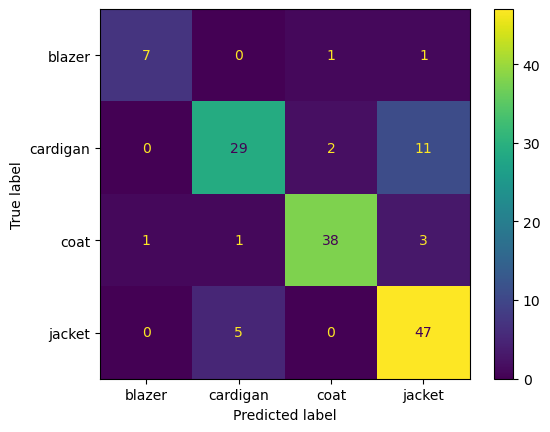

Classification Report:
              precision    recall  f1-score   support

      blazer       0.88      0.78      0.82         9
    cardigan       0.83      0.69      0.75        42
        coat       0.93      0.88      0.90        43
      jacket       0.76      0.90      0.82        52

    accuracy                           0.83       146
   macro avg       0.85      0.81      0.83       146
weighted avg       0.84      0.83      0.83       146

Per class accuracy:
Accuracy of blazer : 77.7778 %
Accuracy of cardigan : 69.0476 %
Accuracy of  coat : 88.3721 %
Accuracy of jacket : 90.3846 %


In [51]:
# load the best model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 4)

model.load_state_dict(torch.load('./model/q2_sgd_0.0005.ckpt'))
model.to(device)

# use best model to test
test(model, dataloader_test)

1. 此結果正確率 82.88%，高於目標 78%
2. 根據先前的預測，我們預期各類別的準確率會是 **jacket > coat > cardigan > blazer**，實際上 **jacket > coat > blazer > cardigan**，從 confusion matrix 去觀察不符預期的原因，可以發現很多 cardigan 都被預測為 jacket，推測很多的 cardigan 可能與 jacket 形狀上長得很像，導致模型有誤判的情形。
3. 可以發現 jacket 也有少數被誤判成 cardigan，因此這兩個類別確實可能會讓模型較難以判斷，而這時模型可能會傾向將模糊地帶的照片判斷為 jacket，因為 jacket 照片比例較高，可以將 loss 降低。

## Q3
模型訓練時固定除了最後一層以外的其他權重。也就是說，模型訓練只會調整最後一層Fully Connected Layer。

### Use SGD
- try learning_rates = [0.005, 0.001, 0.0005, 0.0001]
- try weight_decay = [0, 0.001]

In [52]:
learning_rates = [0.005, 0.001, 0.0005, 0.0001]
weight_decay_list = [0, 0.001]
for lr in learning_rates:
    for wd in weight_decay_list:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        resnet50 = models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad = False

        resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 4)
        resnet50 = resnet50.to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(resnet50.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

        train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q3_sgd_{str(lr)}_{str(wd)}.ckpt", printLossGraph=False, verbose=False)

Learning rate: 0.005, Weight decay: 0
Early stopping at epoch 37
Best Epoch: 16, Training accuracy: 0.6340057253837585, Training loss: 0.892767866452535, Valid accuracy: 0.561904788017273, Valid loss: 0.9584945738315582
Learning rate: 0.005, Weight decay: 0.001
Early stopping at epoch 25
Best Epoch: 4, Training accuracy: 0.5677233338356018, Training loss: 1.032128185936899, Valid accuracy: 0.523809552192688, Valid loss: 0.9839791506528854
Learning rate: 0.001, Weight decay: 0
Early stopping at epoch 78
Best Epoch: 57, Training accuracy: 0.6676272749900818, Training loss: 0.8301419615745544, Valid accuracy: 0.5809524059295654, Valid loss: 0.921508252620697
Learning rate: 0.001, Weight decay: 0.001
Early stopping at epoch 57
Best Epoch: 36, Training accuracy: 0.6416906714439392, Training loss: 0.8549519018693403, Valid accuracy: 0.5714285969734192, Valid loss: 0.9068735539913177
Learning rate: 0.0005, Weight decay: 0
Early stopping at epoch 76
Best Epoch: 55, Training accuracy: 0.6378481

### Use Adam
- try learning_rates = [0.005, 0.001, 0.0005, 0.0001]
- try weight_decay = [0, 0.001]

In [56]:
learning_rates = [0.005, 0.001, 0.0005, 0.0001]
weight_decay_list = [0, 0.001]
for lr in learning_rates:
    for wd in weight_decay_list:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        resnet50 = models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad = False
        
        resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 4)
        resnet50 = resnet50.to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr, weight_decay=wd)

        train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q3_adam_{str(lr)}_{str(wd)}.ckpt", verbose=False, printLossGraph=False)

Learning rate: 0.005, Weight decay: 0
Early stopping at epoch 25
Best Epoch: 4, Training accuracy: 0.5658020973205566, Training loss: 1.0175125562783442, Valid accuracy: 0.5809524059295654, Valid loss: 0.9595505148172379
Learning rate: 0.005, Weight decay: 0.001
Early stopping at epoch 26
Best Epoch: 5, Training accuracy: 0.580211341381073, Training loss: 1.024063710010413, Valid accuracy: 0.6095238327980042, Valid loss: 0.9973391741514206
Learning rate: 0.001, Weight decay: 0
Early stopping at epoch 47
Best Epoch: 26, Training accuracy: 0.6474543809890747, Training loss: 0.8293564716974894, Valid accuracy: 0.561904788017273, Valid loss: 0.9111181944608688
Learning rate: 0.001, Weight decay: 0.001
Early stopping at epoch 46
Best Epoch: 25, Training accuracy: 0.6320844888687134, Training loss: 0.8880208134651184, Valid accuracy: 0.5809524059295654, Valid loss: 0.9203692674636841
Learning rate: 0.0005, Weight decay: 0
Early stopping at epoch 57
Best Epoch: 36, Training accuracy: 0.645533

### 選擇 Adam (valid loss 最低)
- Learning rate: 0.0001, Weight decay: 0.001
- Valid accuracy: 0.6000000238418579
- Valid loss: 0.8947839140892029

Accuracy = 59.5890 %
Confusion Matrix:


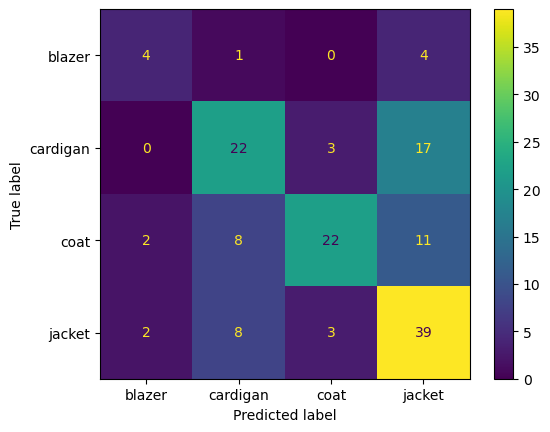

Classification Report:
              precision    recall  f1-score   support

      blazer       0.50      0.44      0.47         9
    cardigan       0.56      0.52      0.54        42
        coat       0.79      0.51      0.62        43
      jacket       0.55      0.75      0.63        52

    accuracy                           0.60       146
   macro avg       0.60      0.56      0.57       146
weighted avg       0.62      0.60      0.59       146

Per class accuracy:
Accuracy of blazer : 44.4444 %
Accuracy of cardigan : 52.3810 %
Accuracy of  coat : 51.1628 %
Accuracy of jacket : 75.0000 %


In [60]:
# load the best model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 4)

model.load_state_dict(torch.load('./model/q3_adam_0.0001_0.001.ckpt'))
model.to(device)

# use best model to test
test(model, dataloader_test)

1. 最終的 test accuracy 為 59.58%
2. 可以發現 resnet 的模型參數不變之下，模型表現會變差，而且差距達 20%
3. 根據先前的預測，我們預期各類別的準確率會是 **jacket > coat > cardigan > blazer**，在此模型中實際上 **jacket > cardigan > coat > blazer**，從 confusion matrix 去觀察不符預期的原因，可以發現很多 cardigan 以及 coat 都被預測為 jacket，所以可見 resnet 裡面的參數在訓練中要做微調才能夠符合這個場景的辨識。

## Q4

不使用預訓練權重初始化模型。

### Use SGD
- try learning_rates = [0.001, 0.0005, 0.0001]
- try weight_decay = [0, 0.001]

In [54]:
learning_rates = [0.001, 0.0005, 0.0001]
weight_decay_list = [0, 0.001]
for lr in learning_rates:
    for wd in weight_decay_list:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        resnet50 = models.resnet50(pretrained=False)

        resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 4)
        resnet50 = resnet50.to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(resnet50.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

        train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q4_sgd_{str(lr)}_{str(wd)}.ckpt", printLossGraph=False, verbose=False)

Learning rate: 0.001, Weight decay: 0
Early stopping at epoch 61
Best Epoch: 40, Training accuracy: 0.42267048358917236, Training loss: 1.2391429543495178, Valid accuracy: 0.43809524178504944, Valid loss: 1.1985281705856323
Learning rate: 0.001, Weight decay: 0.001
Early stopping at epoch 40
Best Epoch: 19, Training accuracy: 0.359269917011261, Training loss: 1.3538346615704624, Valid accuracy: 0.4095238149166107, Valid loss: 1.1818523108959198
Learning rate: 0.0005, Weight decay: 0
Early stopping at epoch 56
Best Epoch: 35, Training accuracy: 0.4073006510734558, Training loss: 1.2802522471456816, Valid accuracy: 0.4095238149166107, Valid loss: 1.1840181648731232
Learning rate: 0.0005, Weight decay: 0.001
Early stopping at epoch 81
Best Epoch: 60, Training accuracy: 0.4073006510734558, Training loss: 1.2665073131069993, Valid accuracy: 0.46666669845581055, Valid loss: 1.1732865273952484
Learning rate: 0.0001, Weight decay: 0
Early stopping at epoch 36
Best Epoch: 15, Training accuracy:

### Use Adam
- try learning_rates = [0.001, 0.0005, 0.0001]
- try weight_decay = [0, 0.001]

In [57]:
learning_rates = [0.001, 0.0005, 0.0001]
weight_decay_list = [0, 0.001]
for lr in learning_rates:
    for wd in weight_decay_list:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        resnet50 = models.resnet50(pretrained=False)
        
        resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 4)
        resnet50 = resnet50.to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr, weight_decay=wd)

        train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=200, model_path=f"./model/q4_adam_{str(lr)}_{str(wd)}.ckpt", verbose=False, printLossGraph=False)

Learning rate: 0.001, Weight decay: 0
Early stopping at epoch 51
Best Epoch: 30, Training accuracy: 0.4438040256500244, Training loss: 1.19017176917105, Valid accuracy: 0.4571428894996643, Valid loss: 1.1345397531986237
Learning rate: 0.001, Weight decay: 0.001
Early stopping at epoch 64
Best Epoch: 43, Training accuracy: 0.4322766363620758, Training loss: 1.2417432828383013, Valid accuracy: 0.41904762387275696, Valid loss: 1.180599331855774
Learning rate: 0.0005, Weight decay: 0
Early stopping at epoch 51
Best Epoch: 30, Training accuracy: 0.5504322648048401, Training loss: 1.0479820135867957, Valid accuracy: 0.4571428894996643, Valid loss: 1.086972676217556
Learning rate: 0.0005, Weight decay: 0.001
Early stopping at epoch 56
Best Epoch: 35, Training accuracy: 0.4995196759700775, Training loss: 1.1207245299310395, Valid accuracy: 0.4761905074119568, Valid loss: 1.1192117929458618
Learning rate: 0.0001, Weight decay: 0
Early stopping at epoch 52
Best Epoch: 31, Training accuracy: 0.49

### 選擇 Adam (valid loss 最低)
- Learning rate: 0.0005, Weight decay: 0
- Valid accuracy: 0.4571428894996643
- Valid loss: 1.086972676217556

Accuracy = 52.7397 %
Confusion Matrix:


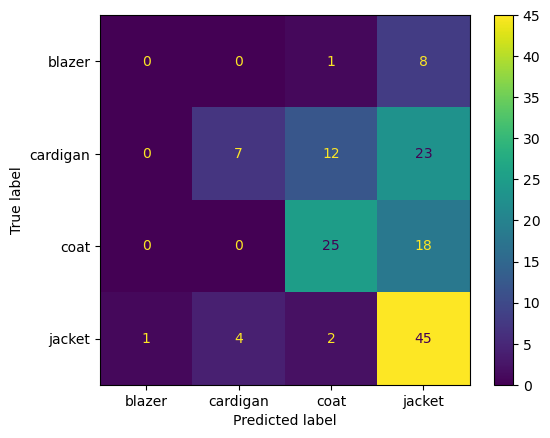

Classification Report:
              precision    recall  f1-score   support

      blazer       0.00      0.00      0.00         9
    cardigan       0.64      0.17      0.26        42
        coat       0.62      0.58      0.60        43
      jacket       0.48      0.87      0.62        52

    accuracy                           0.53       146
   macro avg       0.44      0.40      0.37       146
weighted avg       0.54      0.53      0.47       146

Per class accuracy:
Accuracy of blazer : 0.0000 %
Accuracy of cardigan : 16.6667 %
Accuracy of  coat : 58.1395 %
Accuracy of jacket : 86.5385 %


In [62]:
# load the best model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048, 4)

model.load_state_dict(torch.load('./model/q4_adam_0.0005_0.ckpt'))
model.to(device)

# use best model to test
test(model, dataloader_test)

1. 最終的 test accuracy 為 52.74%
2. 可以發現 resnet 若是不使用 pretrained weight，模型表現會變得更差，對於 blazer 以及 carfigan 幾乎沒有辨別能力。
3. 根據先前的預測，我們預期各類別的準確率會是 **jacket > coat > cardigan > blazer**，實際上 **jacket > coat > cardigan > blazer**，順序與預期相符，但 cardigan 及 blazer 可以發現 f1-score 相當差，blazer 的 accuracy 甚至為 0%。 

## Q5

### 各題的最終 accuracy： Q2 > Q3 > Q4
1. Q2 (pretrained weights): 82.88%
2. Q3 (pretrained weights & fix weight except last layer): 59.58%
3. Q4 (no pretrained weights): 52.74%

### 如果依照各類別預測能力來看： Q2 > Q3 > Q4
1. Q2: jacket(90.38%) > coat(88.37%) > blazer(77.78%) > cardigan(69.05%) 
2. Q3: jacket(75.0000%) > cardigan(52.38%) > coat(51.16%) > blazer(44.44%)
3. Q4: jacket(86.54%) > coat(58.1395%) > cardigan(16.67%) > blazer(0.00%)

### 總結
1. 在很複雜的模型中，dataset 的大小是很重要的，可以看到 Q2 與 Q4 的差別，resnet 的預設參數因為經過大量數據訓練因此可以辨識大多場景，這時候我們只要稍做模型上的調整就可以讓它適應我們的應用情境，而若是只採用架構來訓練，因為照片數量少，因此無法讓 resnet 找到一個適當的參數，模型的準確率就會下降。

2. 在 Q2 及 Q3 的比較中，我們發現只採用 resnet 的預設參數是不夠的，要讓 resnet 的參數隨著應用場景去調整，但 pretrained weight 會讓模型已經在一個不錯的起跑點上，所以未來在各種應用場景上，我們可以找一個相似的應用情景且表現不錯的模型，拿該模型已經有的參數來做微調，可能也會有不錯的效果。

3. optimizer 的挑選上沒有絕對，在 Q2 中最好的是 SGD，在 Q3 及 Q4 卻是 Adam，因此採用哪一種要在嘗試之後才知道。